In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils_eenn_avcs import *
from utils_notebook import get_logits_targets
from models.msdnet import MSDNet_exit
from dataloader import get_dataloaders

from laplace import Laplace

import random

In [28]:
logits, targets, ARGS = get_logits_targets('cifar10', 'models_seed_1', 'softmax', 299, cuda=True)

probs = torch.softmax(logits, dim=2)
preds = get_preds_per_exit(probs)
acc = get_acc_per_exit(preds, targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [2]:
L = 7

models_exit = []
for l in range(L):
    model_l, ARGS = init_model('cifar10', 'models_seed_1', 'softmax', 299, MSDNet_exit, exit=l+1, cuda=True)
    models_exit.append(model_l)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [3]:
train_dataloader, _, test_dataloader = get_dataloaders(ARGS)

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Load train_set_index !!!!!!


In [4]:
LAs = []
for l in range(L):
    la = Laplace(models_exit[l], 'classification', subset_of_weights='last_layer', hessian_structure='full')
    la.fit(train_dataloader)

    log_prior = torch.ones(1, requires_grad=True)
    hyper_optimizer = torch.optim.Adam([log_prior], lr=1e-1)
    for i in range(100):
        hyper_optimizer.zero_grad()
        neg_marglik = - la.log_marginal_likelihood(log_prior.exp())
        neg_marglik.backward()
        hyper_optimizer.step()
        if i % 10 == 0:
            print(f"Epoch {i} | neg_marglik: {neg_marglik.item():.4f}")
            
    LAs.append(la)

Epoch 0 | neg_marglik: 3036.1021
Epoch 10 | neg_marglik: 3036.7759
Epoch 20 | neg_marglik: 3036.2314
Epoch 30 | neg_marglik: 3036.0996
Epoch 40 | neg_marglik: 3036.1079
Epoch 50 | neg_marglik: 3036.1052
Epoch 60 | neg_marglik: 3036.1013
Epoch 70 | neg_marglik: 3036.0996
Epoch 80 | neg_marglik: 3036.0996
Epoch 90 | neg_marglik: 3036.0996
Epoch 0 | neg_marglik: 1637.6639
Epoch 10 | neg_marglik: 1637.2346
Epoch 20 | neg_marglik: 1637.0941
Epoch 30 | neg_marglik: 1637.0625
Epoch 40 | neg_marglik: 1637.0679
Epoch 50 | neg_marglik: 1637.0640
Epoch 60 | neg_marglik: 1637.0630
Epoch 70 | neg_marglik: 1637.0623
Epoch 80 | neg_marglik: 1637.0623
Epoch 90 | neg_marglik: 1637.0620
Epoch 0 | neg_marglik: 885.4897
Epoch 10 | neg_marglik: 878.1923
Epoch 20 | neg_marglik: 878.3848
Epoch 30 | neg_marglik: 878.3463
Epoch 40 | neg_marglik: 878.2181
Epoch 50 | neg_marglik: 878.1787
Epoch 60 | neg_marglik: 878.1866
Epoch 70 | neg_marglik: 878.1780
Epoch 80 | neg_marglik: 878.1790
Epoch 90 | neg_marglik: 87

In [5]:
pred_type='glm'
link_approx='mc'
n_samples_num=100
n_samples_denom=1


probs_num = []
probs_denom = []
for l in range(L):
    probs_num_l = []
    probs_denom_l = []
    targets = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            
            y = y.cuda()
            x = x.cuda()

            input_var = torch.autograd.Variable(x)
            target_var = torch.autograd.Variable(y)

            output_num = LAs[l](input_var, n_samples=n_samples_num, pred_type=pred_type, link_approx=link_approx)
            output_denom = LAs[l](input_var, n_samples=n_samples_denom, pred_type=pred_type, link_approx=link_approx)

            probs_num_l.append(output_num)
            probs_denom_l.append(output_denom)
            targets.append(target_var)

    probs_num_l = torch.cat(probs_num_l, dim=0).cpu()
    probs_denom_l = torch.cat(probs_denom_l, dim=0).cpu()
    targets = torch.cat(targets).cpu()
    probs_num.append(probs_num_l)
    probs_denom.append(probs_denom_l)

probs_num = torch.stack(probs_num, dim=0)
probs_denom = torch.stack(probs_denom, dim=0)

In [24]:
preds = get_preds_per_exit(probs_num)
acc = get_acc_per_exit(preds, targets)
acc

[tensor(0.8977),
 tensor(0.9082),
 tensor(0.9187),
 tensor(0.9220),
 tensor(0.9228),
 tensor(0.9251),
 tensor(0.9254)]

In [14]:
# torch.save((probs_num, probs_denom), f"eenn_avcs_results/cifar10/nn_mc_100.pth")
# probs_num, probs_denom = torch.load("eenn_avcs_results/cifar10/nn_mc_100.pth")  # TODO: add targets here

# torch.save((probs_num, probs_denom, targets), f"eenn_avcs_results/cifar10/glm_mc_100.pth")

In [42]:
alpha = 0.1
L, N, C = probs_num.shape

R_all = torch.div(probs_num, probs_denom).cumprod(axis=0)
C_all = []
for i in range(N):
    R_i = R_all[:, i, :].cpu().numpy()
    C_i = [list(np.where(row <= 1 / alpha)[0]) for row in R_i]
    C_all.append(running_intersection_classification(C_i))

In [43]:
sizes = []
coverage = []
for i in range(N):
    sizes.append([len(C_all[i][l]) for l in range(L)])
    coverage.append([targets[i] in C_all[i][l] for l in range(L)])

sizes = np.array(sizes)
coverage = np.array(coverage)

In [44]:
# _, _, conf_sets, conf_labels = raps_eenn(probs_num.cpu().numpy(), targets, alpha=alpha)
_, _, conf_sets, conf_labels = raps_eenn(probs.cpu().numpy(), targets, alpha=alpha)
conf_sets = [[list(np.where(x)[0]) for x in conf_sets[l]] for l in range(L)]
conf_sets = [[conf_sets[l][i] for l in range(L)] for i in range(len(conf_sets[0]))]
conf_sets_intersect = [running_intersection_classification(conf_sets[i]) for i in range(len(conf_sets))]

conf_sets_sizes = np.array([[len(conf_sets[i][l]) for l in range(L)] for i in range(len(conf_sets))])
conf_sets_coverage = np.array([[conf_labels[0][i] in conf_sets[i][l] for l in range(L)] for i in range(len(conf_sets))])

conf_sets_intersect_sizes = np.array([[len(conf_sets_intersect[i][l]) for l in range(L)] for i in range(len(conf_sets_intersect))])
conf_sets_intersect_coverage = np.array([[conf_labels[0][i] in conf_sets_intersect[i][l] for l in range(L)] for i in range(len(conf_sets_intersect))])

In [45]:
consistency_conformal = np.array([consistency_classifciation(conf_sets[i]) for i in range(len(conf_sets[0]))])
consistency_conformal_intersect = np.array([consistency_classifciation(conf_sets_intersect[i]) for i in range(len(conf_sets_intersect[0]))])
consistency_avcs = np.array([consistency_classifciation(C_all[i]) for i in range(N)])

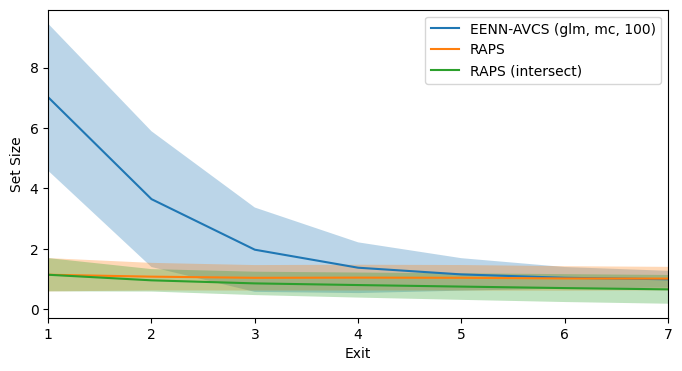

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
exits = [l + 1 for l in range(L)]

ax.plot(exits, sizes.mean(axis=0), label=f'EENN-AVCS ({pred_type}, mc, 100)')
ax.fill_between(exits, sizes.mean(axis=0) - sizes.std(axis=0), sizes.mean(axis=0) + sizes.std(axis=0), alpha=0.3)


ax.plot(exits, conf_sets_sizes.mean(axis=0), label='RAPS')
ax.fill_between(exits, conf_sets_sizes.mean(axis=0) - conf_sets_sizes.std(axis=0), conf_sets_sizes.mean(axis=0) + conf_sets_sizes.std(axis=0), alpha=0.3)

ax.plot(exits, conf_sets_intersect_sizes.mean(axis=0), label='RAPS (intersect)')
ax.fill_between(exits, conf_sets_intersect_sizes.mean(axis=0) - conf_sets_intersect_sizes.std(axis=0), conf_sets_intersect_sizes.mean(axis=0) + conf_sets_intersect_sizes.std(axis=0), alpha=0.3)

ax.set_xlabel('Exit')
ax.set_ylabel('Set Size')
ax.set_xlim([1, L])
ax.legend()

plt.show()

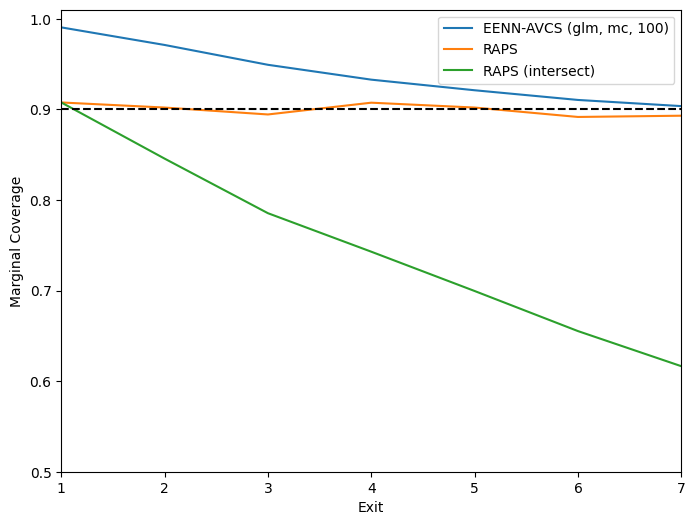

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
exits = [l + 1 for l in range(L)]


ax.plot(exits, coverage.mean(axis=0), label=f'EENN-AVCS ({pred_type}, mc, 100)')
ax.plot(exits, conf_sets_coverage.mean(axis=0), label='RAPS')
ax.plot(exits, conf_sets_intersect_coverage.mean(axis=0), label='RAPS (intersect)')

ax.axhline(y=1 - alpha, color='black', linestyle='--')

ax.set_xlabel('Exit')
ax.set_ylabel('Marginal Coverage')

ax.set_ylim([0.5, 1.01])
ax.set_xlim([1, L])
ax.legend()

plt.show()

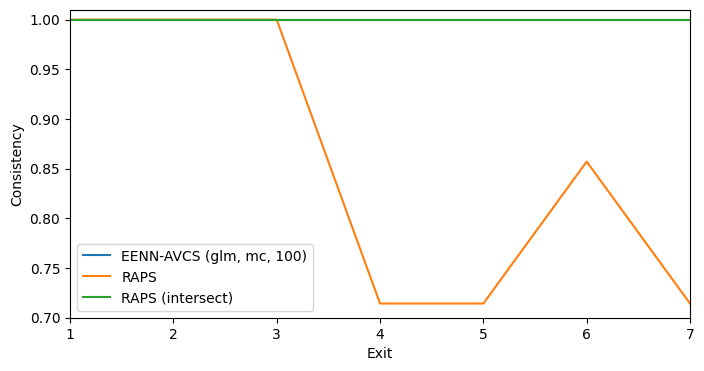

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))
exits = [l + 1 for l in range(L)]

ax.plot(exits, consistency_avcs.mean(axis=0), label=f'EENN-AVCS ({pred_type}, mc, 100)')
ax.plot(exits, consistency_conformal.mean(axis=0), label='RAPS')
ax.plot(exits, consistency_conformal_intersect.mean(axis=0), label='RAPS (intersect)')

ax.set_xlabel('Exit')
ax.set_ylabel('Consistency')

ax.set_ylim([0.7, 1.01])
ax.set_xlim([1, L])
ax.legend()

plt.show()